## Exploring changes in primary education in relation to child and maternal health improvements

***Abstract***

Many countries have significantly improved the provision of health services to new-born children and their mothers. As a result, maternal and infant mortality rates have been drastically lowered, and children increasingly immunized from diseases like measles. An interesting question arises, however, regarding the future of the generation of children whose lives have been saved by the improving conditions in their countries. How have their countries’ educational systems managed with the new influx of children into primary schools? In this study, the Millennium Development Goals (MDG) dataset will be used to explore this topic particularly in the case of least developed countries (LDCs).

***Problem and Motivation***

It is important to analyze whether LDC educational systems are equipped to deal with a healthier and greater child population. By studying the trends of LDCs that have improved upon their maternal and child healthcare, we can learn how such countries have served children who are accessing more and more educational resources. The insights taken from such an analysis can shape development policy and government resource allocation into two seemingly disparate but highly interrelated sectors: healthcare and education.

***Approaches***

All the data used in this study was taken from the MDG Dataset made available on the United Nations MDG website. The most important variables explored are related to goals 2, 3, 4 and 5 of the MDGs. We first challenge the assumption that maternal and child healthcare have improved significantly in LDCs (e.g. by exploring maternal and infant mortality rates). Upon asserting this assumption, we ask if these countries have also improved upon their primary education goals (e.g. primary education completion rate). And finally, we perform a Singular Value Decomposition (SVD) analysis to get a general understanding of the improvement of primary education in LDCs compared to their developed counterparts.

***Tools***

This project relies heavily on the Python programming language and, in particular, the data analysis package for Python called pandas. This package allows users to wrangle, clean, index, aggregate, visualize, model and perform many other operations on large datasets. Other packages used include NumPy for numerical manipulations, SciPy for SVD analysis, and Matplotlib for visualizations.

***Results***

The results of the project reveal that the drastic improvements that many LDCs have demonstrated in their maternal and child healthcare have not encumbered their improvements in primary education. Malawi, for example, is a country that is shown to be a leader in improvements in both sectors. While this result is a very encouraging result, it leads us to further questions about how countries like Malawi have balanced the betterment of their child healthcare with the provision of quality primary education. What lessons can be learned from the country’s government policy? This is a development question that can only be answered through analyzing economic, fiscal and population data coming out of the country.



In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib_venn import venn2
from matplotlib_venn import venn3

## Getting and cleaning data

First, let us load the dataset

In [2]:
url = 'C:\Users\Kidus\Desktop\MdgDatabase_2015WSD_DataVizChallenge_.txt'
raw_data = pd.read_csv(url,sep='\t')
raw_data.head()
#there are some data problems, but those will be cleaned

C:\Users\Kidus\Anaconda\lib\site-packages\pandas\io\parsers.py:1130: DtypeWarning: Columns (6,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


GoalId                                     GoalName  TargetId  \
0       7  Goal 7. Ensure environmental sustainability         9   
1       7  Goal 7. Ensure environmental sustainability         9   
2       7  Goal 7. Ensure environmental sustainability         9   
3       7  Goal 7. Ensure environmental sustainability         9   
4       7  Goal 7. Ensure environmental sustainability         9   

                                          TargetName  IndicatorId  \
0  Target 7.A: Integrate the principles of sustai...           25   
1  Target 7.A: Integrate the principles of sustai...           25   
2  Target 7.A: Integrate the principles of sustai...           25   
3  Target 7.A: Integrate the principles of sustai...           25   
4  Target 7.A: Integrate the principles of sustai...           25   

                                   IndicatorName IndicatorOrderClause  \
0  7.1 Proportion of land area covered by forest                  7.1   
1  7.1 Proportion of land area covered by forest                  7.1   
2  7.1 Proportion of land area covered by forest                  7.1   
3  7.1 Proportion of land area covered by forest                  7.1   
4  7.1 Proportion of land area covered by forest                  7.1   

   SeriesRowId                                         SeriesName  \
0          567  Proportion of land area covered by forest, per...   
1          567  Proportion of land area covered by forest, per...   
2          567  Proportion of land area covered by forest, per...   
3          567  Proportion of land area covered by forest, per...   
4          567  Proportion of land area covered by forest, per...   

   SeriesOrderClause        ...          IsFormer IsLDC2014  IsLLDC GDPpc2012  \
0               7101        ...                 0         1       1     682.8   
1               7101        ...                 0         1       1     682.8   
2               7101        ...                 0         1       1     682.8   
3               7101        ...                 0         1       1     682.8   
4               7101        ...                 0         0       0    3809.0   

  Population2012  Year  Value  Nature  FootnoteId  FootnoteText  
0       29824536  1990   2.07       E         NaN           NaN  
1       29824536  2000   2.07       E         NaN           NaN  
2       29824536  2005   2.07       E         NaN           NaN  
3       29824536  2010   2.07       E         NaN           NaN  
4        3162083  1990  28.79       C         NaN           NaN  

[5 rows x 28 columns]

Now, we can clean the data. The dataset contains a few records with missing data in columns which will be used extensively. We will thus drop rows where:
* The 'MdgRegions' field is empty (e.g. Union of Soviet Socialist Republics (Former))
* The 'ISO3Code' field is empty
* The 'IsLDC2014' field is empty
* The combination of 'ISO3Code','SeriesOrderClause' and 'Year' columns are repeated (as this is a unique constraint)
* The combination of 'CountryName','SeriesOrderClause' and 'Year' columns are repeated (as this is a unique constraint)

In [3]:
raw_data = raw_data.drop(raw_data[pd.isnull(raw_data['MdgRegions'])].index,axis=0)
raw_data = raw_data.drop(raw_data[pd.isnull(raw_data['ISO3Code'])].index,axis=0)
raw_data = raw_data.drop(raw_data[pd.isnull(raw_data['IsLDC2014'])].index,axis=0)
raw_data.drop_duplicates(subset=['ISO3Code','SeriesOrderClause','Year'],inplace=True)
raw_data.drop_duplicates(subset=['CountryName','SeriesOrderClause','Year'],inplace=True)

The data is presented in a long-format that conforms to relational databases like SQL, but we want it in wide-format where each row represents the indicator measurements for a country for a particular year. We also only want to keep the most relevant attributes.

In [4]:
hier_data = raw_data[['MdgRegions','CountryId','ISO3Code','CountryName','IsLDC2014','SeriesOrderClause','Year','Value']].set_index(['MdgRegions','CountryId','ISO3Code','CountryName','IsLDC2014','SeriesOrderClause','Year']).unstack().stack(dropna=False)

In [5]:
hier_data.head()

Value
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 SeriesOrderClause Year       
Caribbean  28        ATG      Antigua and Barbuda 0         1105              1983    NaN
                                                                              1984    NaN
                                                                              1985    NaN
                                                                              1986    NaN
                                                                              1987    NaN

As can be seen above for the data for Antigua and Barbuda, there is quite a bit of missing data. Let us forward-fill our data so that missing data can be imputed using prior year values. We then back-fill our data so that earlier years can be also be filled. This will ensure that we have data to allow us to perform dimensionality reduction using Singular Value Decomposition while also allowing us to use the most recent information to deduce missing data for a given country

In [6]:
hier_data['Value'] = hier_data.groupby(level=['CountryId','SeriesOrderClause'])['Value'].ffill()
hier_data['Value'] = hier_data.groupby(level=['CountryId','SeriesOrderClause'])['Value'].bfill()
hier_data.head()

Value
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 SeriesOrderClause Year       
Caribbean  28        ATG      Antigua and Barbuda 0         1105              1983    2.2
                                                                              1984    2.2
                                                                              1985    2.2
                                                                              1986    2.2
                                                                              1987    2.2

Let's see our data where each country gets exactly one row for each year with columns representing MDG indicators

In [7]:
hier_data.unstack(level='SeriesOrderClause').head()

Value  \
SeriesOrderClause                                                 1101    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year          
Caribbean  28        ATG      Antigua and Barbuda 0         1983    NaN   
                                                            1984    NaN   
                                                            1985    NaN   
                                                            1986    NaN   
                                                            1987    NaN   

                                                                         \
SeriesOrderClause                                                 1102    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year          
Caribbean  28        ATG      Antigua and Barbuda 0         1983    NaN   
                                                            1984    NaN   
                                                            1985    NaN   
                                                            1986    NaN   
                                                            1987    NaN   

                                                                         \
SeriesOrderClause                                                 1103    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year          
Caribbean  28        ATG      Antigua and Barbuda 0         1983    NaN   
                                                            1984    NaN   
                                                            1985    NaN   
                                                            1986    NaN   
                                                            1987    NaN   

                                                                         \
SeriesOrderClause                                                 1104    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year          
Caribbean  28        ATG      Antigua and Barbuda 0         1983    NaN   
                                                            1984    NaN   
                                                            1985    NaN   
                                                            1986    NaN   
                                                            1987    NaN   

                                                                         \
SeriesOrderClause                                                 1105    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year          
Caribbean  28        ATG      Antigua and Barbuda 0         1983    2.2   
                                                            1984    2.2   
                                                            1985    2.2   
                                                            1986    2.2   
                                                            1987    2.2   

                                                                         \
SeriesOrderClause                                                 1201    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year          
Caribbean  28        ATG      Antigua and Barbuda 0         1983    NaN   
                                                            1984    NaN   
                                                            1985    NaN   
                                                            1986    NaN   
                                                            1987    NaN   

                                                                         \
SeriesOrderClause                                                 1301    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year          
Caribbean  28        ATG      Antigua and Barbuda 0         1983    NaN   
                                                            1984    NaN   
                                                            1985    NaN   
          

It appears Antigua still has missing data for indicator order clause 1101 and several others. This is because we forward-filled and back-filled within the country's data between 1983 and 2015. If there has been no data for all years for indicator 1101, we will have nothing to forward and back-fill.
To fill this kind of missing data, let us substitute using the region's average.

In [8]:
hier_data = hier_data.unstack(level='SeriesOrderClause').stack(dropna=False)
hier_data['Value'] = hier_data.groupby(level=['MdgRegions','SeriesOrderClause'])['Value'].transform(lambda x: x.fillna(x.mean()))
hier_data.unstack(level = 'SeriesOrderClause').head()

Value  \
SeriesOrderClause                                                     1101    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year              
Caribbean  28        ATG      Antigua and Barbuda 0         1983  18.668727   
                                                            1984  18.668727   
                                                            1985  18.668727   
                                                            1986  18.668727   
                                                            1987  18.668727   

                                                                             \
SeriesOrderClause                                                     1102    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year              
Caribbean  28        ATG      Antigua and Barbuda 0         1983  39.035354   
                                                            1984  39.035354   
                                                            1985  39.035354   
                                                            1986  39.035354   
                                                            1987  39.035354   

                                                                             \
SeriesOrderClause                                                     1103    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year              
Caribbean  28        ATG      Antigua and Barbuda 0         1983  28.082828   
                                                            1984  28.082828   
                                                            1985  28.082828   
                                                            1986  28.082828   
                                                            1987  28.082828   

                                                                            \
SeriesOrderClause                                                    1104    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year             
Caribbean  28        ATG      Antigua and Barbuda 0         1983  54.30202   
                                                            1984  54.30202   
                                                            1985  54.30202   
                                                            1986  54.30202   
                                                            1987  54.30202   

                                                                         \
SeriesOrderClause                                                 1105    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year          
Caribbean  28        ATG      Antigua and Barbuda 0         1983    2.2   
                                                            1984    2.2   
                                                            1985    2.2   
                                                            1986    2.2   
                                                            1987    2.2   

                                                                            \
SeriesOrderClause                                                    1201    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year             
Caribbean  28        ATG      Antigua and Barbuda 0         1983  8.596485   
                                                            1984  8.596485   
                                                            1985  8.596485   
                                                            1986  8.596485   
                                                            1987  8.596485   

                                                                            \
SeriesOrderClause                                                    1301    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year             
Caribbean  28        ATG      Antigua and Barbuda 0         1983  4.600545   
        

Much better

Note that the indicator with SeriesOrderClause 8802 (Agricultural Support Estimate for OECD countries) is still missing for Antigua and Barbuda. This means that the Caribbean region has no data whatsoever on any year for this indicator. Let us remove such indicators that are unfilled within one or more region. This will be our clean data

In [9]:
clean_data = hier_data.drop([8101,8102,8103,8104,8201,8202,8301,8302,8401,8402,8501,8502,8601,8602,8801,8802,8901,81101,81102,1902,7904,7905,6104,6105,6201,6202,6401,6402,6404,6505,6701,6801,7202,7204,7206,6601,6602,6603],level='SeriesOrderClause',inplace=False)
clean_data.unstack(level = 'SeriesOrderClause').head()

Value  \
SeriesOrderClause                                                     1101    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year              
Caribbean  28        ATG      Antigua and Barbuda 0         1983  18.668727   
                                                            1984  18.668727   
                                                            1985  18.668727   
                                                            1986  18.668727   
                                                            1987  18.668727   

                                                                             \
SeriesOrderClause                                                     1102    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year              
Caribbean  28        ATG      Antigua and Barbuda 0         1983  39.035354   
                                                            1984  39.035354   
                                                            1985  39.035354   
                                                            1986  39.035354   
                                                            1987  39.035354   

                                                                             \
SeriesOrderClause                                                     1103    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year              
Caribbean  28        ATG      Antigua and Barbuda 0         1983  28.082828   
                                                            1984  28.082828   
                                                            1985  28.082828   
                                                            1986  28.082828   
                                                            1987  28.082828   

                                                                            \
SeriesOrderClause                                                    1104    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year             
Caribbean  28        ATG      Antigua and Barbuda 0         1983  54.30202   
                                                            1984  54.30202   
                                                            1985  54.30202   
                                                            1986  54.30202   
                                                            1987  54.30202   

                                                                         \
SeriesOrderClause                                                 1105    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year          
Caribbean  28        ATG      Antigua and Barbuda 0         1983    2.2   
                                                            1984    2.2   
                                                            1985    2.2   
                                                            1986    2.2   
                                                            1987    2.2   

                                                                            \
SeriesOrderClause                                                    1201    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year             
Caribbean  28        ATG      Antigua and Barbuda 0         1983  8.596485   
                                                            1984  8.596485   
                                                            1985  8.596485   
                                                            1986  8.596485   
                                                            1987  8.596485   

                                                                            \
SeriesOrderClause                                                    1301    
MdgRegions CountryId ISO3Code CountryName         IsLDC2014 Year             
Caribbean  28        ATG      Antigua and Barbuda 0         1983  4.600545   
        

Let us now focus on least developed countries (LDCs)

In [10]:
clean_LDC_data = clean_data.xs(1,level='IsLDC2014')
clean_LDC_data.head()

Value
MdgRegions CountryId ISO3Code CountryName Year SeriesOrderClause       
Caribbean  332       HTI      Haiti       1983 1101               61.71
                                               1102               58.50
                                               1103               40.60
                                               1104               74.90
                                               1105                1.84

## Exploring child and maternal healthcare

Let us write a function which, given an indicator, will output a bar plots showing improvements on that indicator by region.

In [12]:
def show_LDC_improvement_by_region(indicator,data=clean_LDC_data,start_yr=1990,end_yr=2015,width=0.35):
    sns.set_style('darkgrid')
    fig = plt.figure(figsize=(6,5))
    N=6 #distinct MdgRegions that have LDC countries
    ind = np.arange(N)
    ax = fig.add_subplot(1,1,1)
    series_name = raw_data.query('SeriesOrderClause=='+str(indicator))[:1].SeriesName.values[0]
    indicator_data = data.xs(indicator,level='SeriesOrderClause').loc(axis=0)[:,:,:,:,[start_yr,end_yr]]
    grouped = indicator_data.groupby(level=['MdgRegions','Year'])
    mean_data = grouped.mean()
    b = ax.bar(ind,mean_data.xs(start_yr,level='Year').values,width)
    b2 = ax.bar(ind+width,mean_data.xs(end_yr,level='Year').values,width,color = '#33aa77')
    xticks_pos = [bar.get_xy()[0]+0.5 for bar in b]
    plt.xticks(xticks_pos, ['Caribbean','Oceania','South-eastern Asia','Southern Asia','Sub-Saharan Africa','Western Asia'],  ha='right', rotation=90)
    fig.suptitle(series_name, fontsize=14)
    plt.legend([b[0],b2[0]],[start_yr,end_yr])
    plt.show()
  
    

### Maternal healthcare

Let us now check improvements on maternal mortality ratio (indicator 5101)

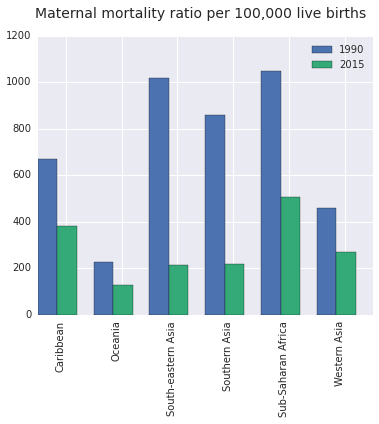

In [13]:
show_LDC_improvement_by_region(5101)

And now improvements on births attended by skilled health personnel (as a percentage)

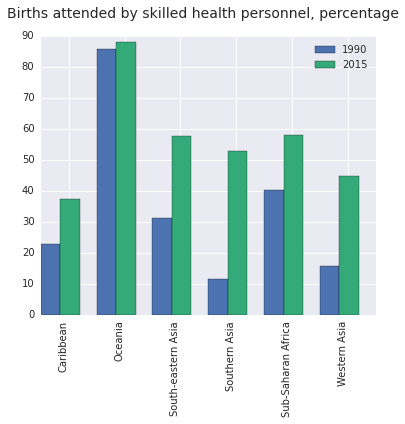

In [14]:
show_LDC_improvement_by_region(5201)

On average, we can see that least developed countries have made significant strides in improving on these maternal health indicators. We can also learn from below that many of the countries that have made the highest improvements in maternal mortality ratio are also the countries with highest growths in births attended by skilled professionals.

In [15]:
def best_LDC_improvement(indicator,low_is_good = True, n_top=20, data=clean_LDC_data, start_yr = 1990, end_yr=2015):
    indicator_data = clean_LDC_data.xs(indicator,level='SeriesOrderClause')
    delta_data = indicator_data.groupby(level=['MdgRegions','CountryId','CountryName','ISO3Code']).agg(lambda x:(x.values[-1:] - x.values[:1])[0])#.xs(start_yr,level='Year').values)
    if low_is_good:
        return delta_data.sort_index(by='Value')[:n_top]
    else:
        return delta_data.sort_index(by='Value')[-n_top:]


In [16]:
def create_Venn2(ind1,ind2,*labels):
    best1 = set(best_LDC_improvement(ind1[0],low_is_good=ind1[1]).index.get_level_values('CountryName').values)
    best2 = set(best_LDC_improvement(ind2[0],low_is_good=ind2[1]).index.get_level_values('CountryName').values)
    v = venn2([best1,best2],set_labels = [labels[0],labels[1]])
    intersection = [c.replace("Lao People's Democratic Republic", "Laos") for c in list(best1&best2)]
    series_name1 = raw_data.query('SeriesOrderClause=='+str(ind1[0]))[:1].SeriesName.values[0]
    series_name2 = raw_data.query('SeriesOrderClause=='+str(ind2[0]))[:1].SeriesName.values[0]
    plt.title("Intersection of countries with top-20 improvements in \n" + series_name1 + " and \n" + series_name2)
    plt.annotate('\n '.join(intersection), xy=v.get_label_by_id('11').get_position() + np.array([0, 0.03]), xytext=(210,20),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',color='black'))
    plt.show()

As can be seen below, many of the countries that have made the highest improvements in maternal mortality ratio are also the countries that have seen the highest growths in births attended by skilled professionals.

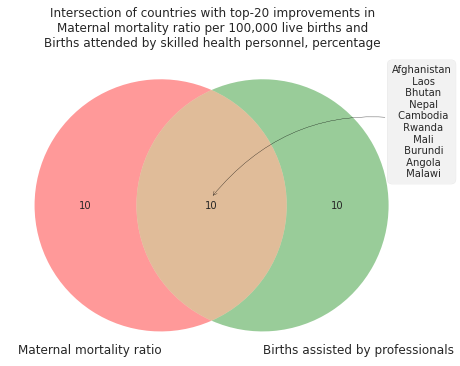

In [17]:
create_Venn2((5101,True),(5201,False),"Maternal mortality ratio","Births assisted by professionals")

Assuming that the two indicators used above are good proxies for maternal health, we can say LDCs are making meaningful progress in this aspect of their healthcare. Let us now investigate some child health indicators

### Child healthcare

Let us now check improvements on child mortality ratio (indicator 4101)

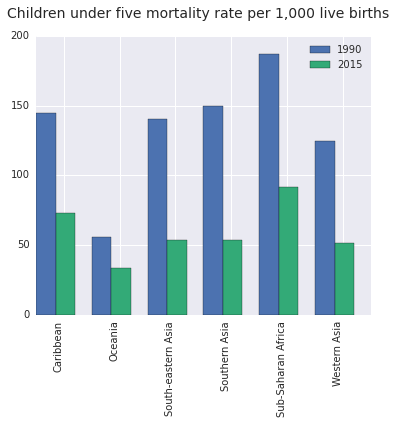

In [18]:
show_LDC_improvement_by_region(4101)

And now infant (age 0-1) mortality rate

In [19]:
show_LDC_improvement_by_region(4201)

And finally, let's check rate of immunization against measles

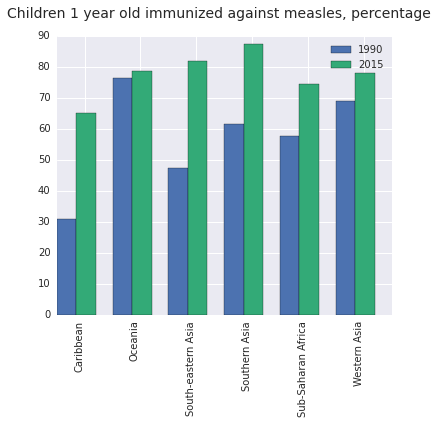

In [20]:
show_LDC_improvement_by_region(4301)

Once again, we note that there are large intersections among the countries that are doing well in improving upon these indicators

In [21]:
def create_Venn3(ind1,ind2,ind3,*labels):
    best1 = set(best_LDC_improvement(ind1[0],low_is_good=ind1[1]).index.get_level_values('CountryName').values)
    best2 = set(best_LDC_improvement(ind2[0],low_is_good=ind2[1]).index.get_level_values('CountryName').values)
    best3 = set(best_LDC_improvement(ind3[0],low_is_good=ind2[1]).index.get_level_values('CountryName').values)
    v = venn3([best1,best2,best3],set_labels = [labels[0],labels[1],labels[2]])
    intersection = [c.replace("Lao People's Democratic Republic", "Laos") for c in list(best1&best2&best3)]
    series_name1 = raw_data.query('SeriesOrderClause=='+str(ind1[0]))[:1].SeriesName.values[0]
    series_name2 = raw_data.query('SeriesOrderClause=='+str(ind2[0]))[:1].SeriesName.values[0]
    series_name3 = raw_data.query('SeriesOrderClause=='+str(ind3[0]))[:1].SeriesName.values[0]
    plt.title("Intersection of countries with top-20 improvements in \n" + series_name1 + " ,\n" + series_name2 + " and\n" + series_name3 + "\n")
    plt.annotate('\n '.join(intersection), xy=v.get_label_by_id('111').get_position() + np.array([0, 0.04]), xytext=(200,20),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',color='black'))
    plt.show()

Note, once again, that there are many intersections in the LDCs that have made the best improvements on these child health indicators. ***Rwanda*** and ***Malawi*** are of note as they were also two of the best improvers in maternal health indicators.

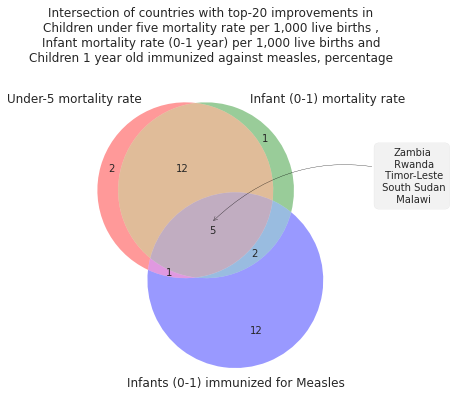

In [23]:
create_Venn3((4101,True),(4201,True),(4301,False),"Under-5 mortality rate","Infant (0-1) mortality rate", "Infants (0-1) immunized for Measles")

Assuming that the three indicators used above are good proxies for child health, we can also say LDCs are making meaningful progress in this aspect of their healthcare.

## Exploring primary education

Let us now explore the main question of this presentation. It is apparent that LDCs have made advancements in improving their child and maternal health. Have these successes, however, strained these countries' educational systems by producing more children in need of quality primary education? We will use the six primary education indicators below in the dataset to explore this question. The breakdown of these indicators based on sex is crucial because we want to investigate if countries have continued their efforts at making education accessible to both sexes while advancing their primary education goals.
* Total net enrolment ratio in primary education, both sexes
* Total net enrolment ratio in primary education, boys
* Total net enrolment ratio in primary education, girls
* Primary education completion rate, both sexes
* Primary education completion rate, boys
* Primary education completion rate, girls


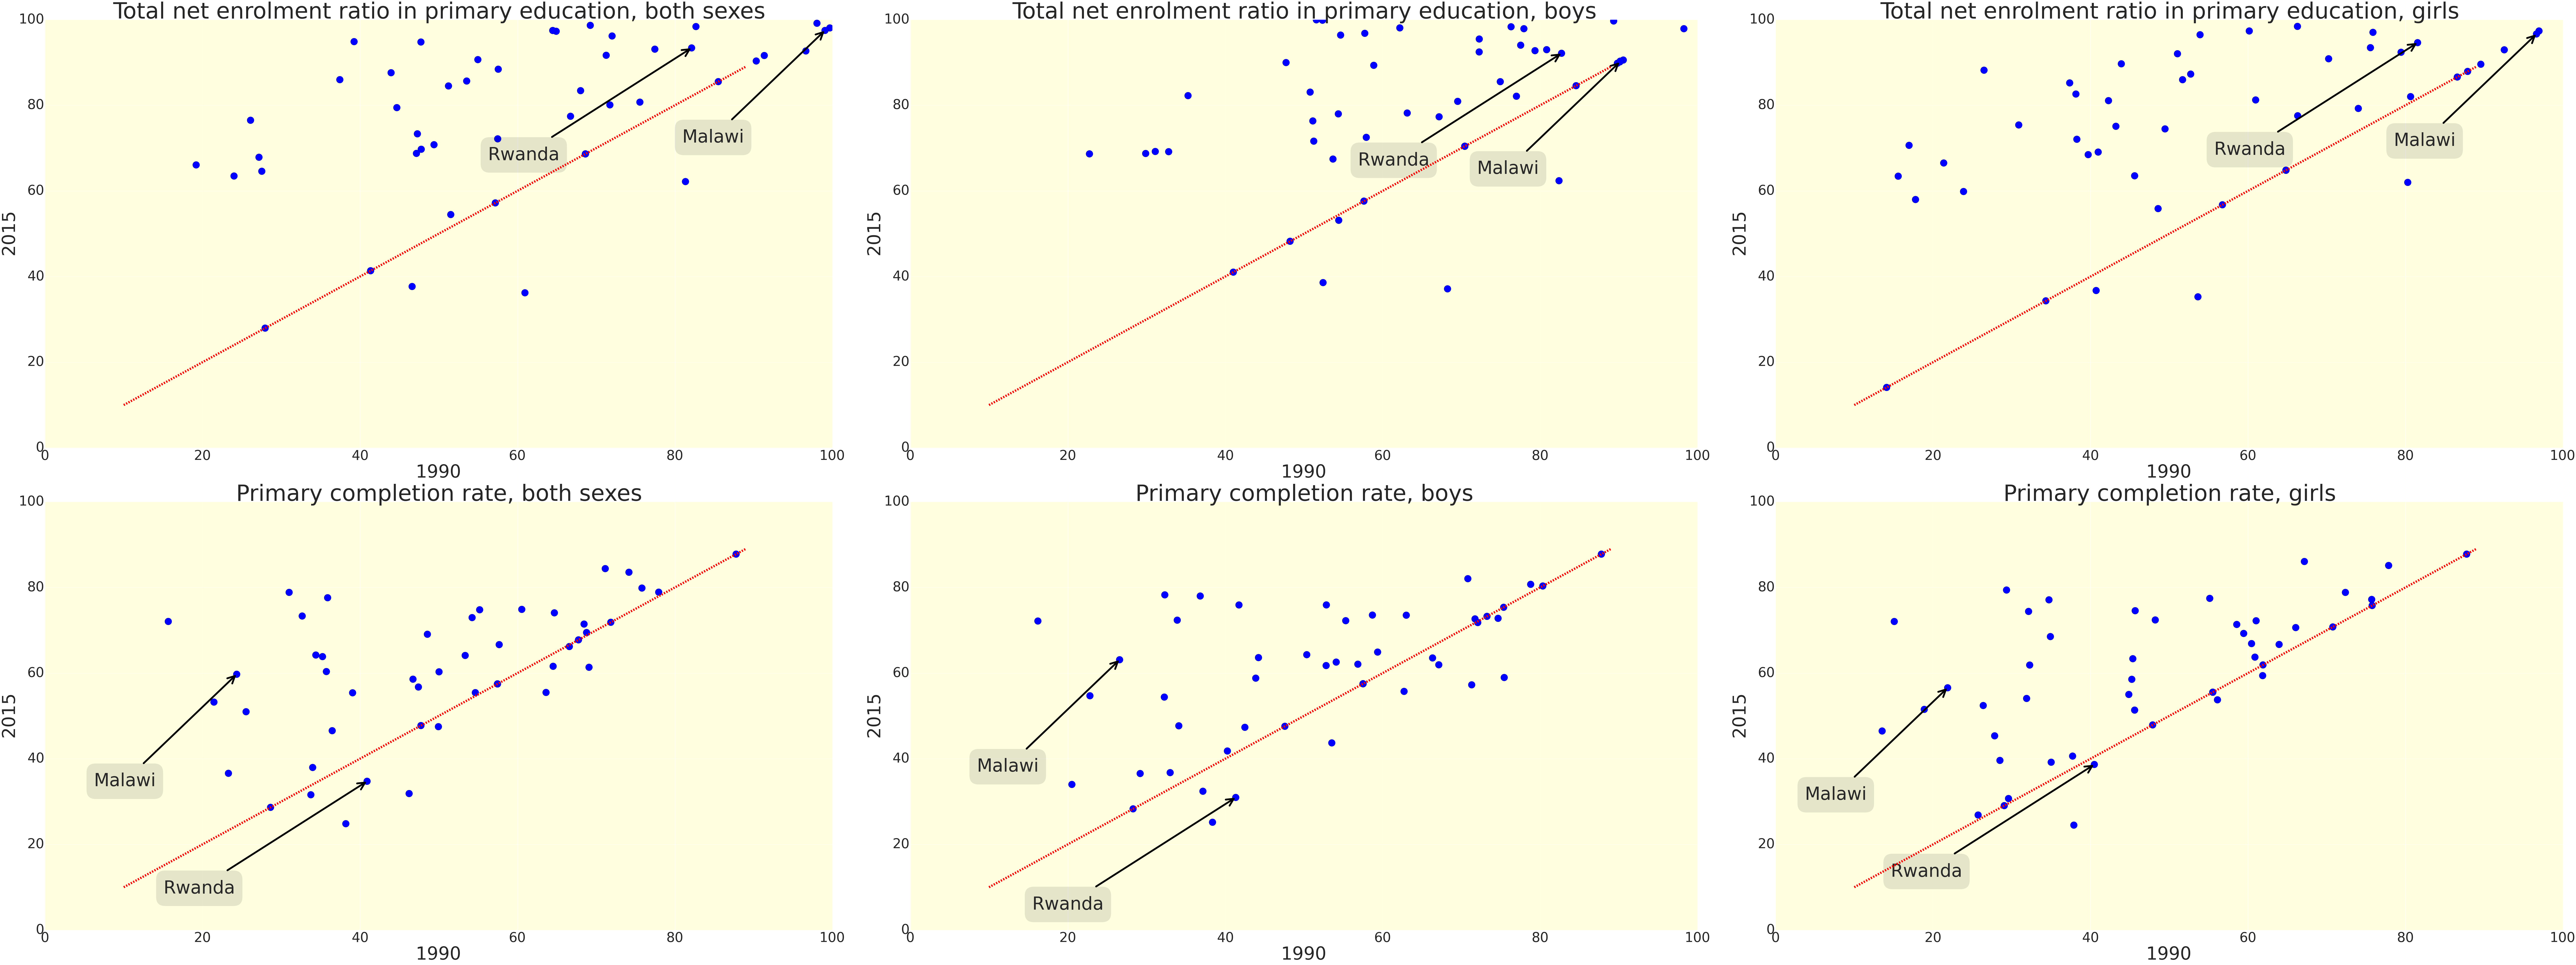

In [24]:
#Let's consider Rwanda and Malawi, two of our best performers in child and maternal health improvements
start_yr = 1990
end_yr = 2015
indicator_lst = [2101,2102,2103,2201,2202,2203]   #leaving out 2204,2205,2301,2302,2303,2304,3101,3102,3103
data = clean_LDC_data

fig,axes = plt.subplots(2,3,figsize=(160,60))
#fig.suptitle("Most LDC countries have significantly improved (above red line) on educational indicators")
plt.rcParams.update({'axes.titlesize': 'medium'})
idx = pd.IndexSlice
x = range(10,90)
y = range(10,90)
for i in xrange(len(indicator_lst)):
    indicator = indicator_lst[i]
    r,c = i/3,i%3
    if indicator in (2101,2102,2103):
        series_name = raw_data.query('SeriesOrderClause=='+str(indicator))[:1].SeriesName.values[0]
    elif indicator == 2201:
        series_name = 'Primary completion rate, both sexes'
    elif indicator == 2202:
        series_name = 'Primary completion rate, boys'
    else:
        series_name = 'Primary completion rate, girls'
    indicator_data = data.loc[idx[['Caribbean','Oceania','South-eastern Asia','Southern Asia','Sub-Saharan Africa','Western Asia'],:,:,:,[start_yr,end_yr],indicator]]
    axes[r,c].set_axis_bgcolor('#FFFFE0')
    axes[r,c].scatter(indicator_data.xs(start_yr,level='Year').Value.values,indicator_data.xs(end_yr,level='Year').Value.values,s=1000)
  
    axes[r,c].plot(x,y, 'r', linewidth=10.0,linestyle="dashed",zorder=10)
    axes[r,c].annotate('Rwanda', xy=(indicator_data.xs((start_yr,'Rwanda'),level=['Year','CountryName']).Value.values[0],indicator_data.xs((end_yr,'Rwanda'),level=['Year','CountryName']).Value.values[0]), xytext=(-750,-500),
             ha='center', textcoords='offset points', fontsize = 80, bbox=dict(boxstyle='round,pad=0.5', fc='black', alpha=0.1),
             arrowprops=dict(arrowstyle='->',color='black',lw=8))
    axes[r,c].annotate('Malawi', xy=(indicator_data.xs((start_yr,'Malawi'),level=['Year','CountryName']).Value.values[0],indicator_data.xs((end_yr,'Malawi'),level=['Year','CountryName']).Value.values[0]), xytext=(-500,-500),
             ha='center', textcoords='offset points', fontsize = 80, bbox=dict(boxstyle='round,pad=0.5', fc='black', alpha=0.1),
             arrowprops=dict(arrowstyle='->',color='black',lw=8))
    axes[r,c].set_title(series_name,fontsize=100)
    axes[r,c].set_xlabel(start_yr,fontsize=80)
    axes[r,c].set_ylabel(end_yr,fontsize=80)
    axes[r,c].set_xlim([0,100])
    axes[r,c].set_ylim([0,100])
    plt.setp(axes[r,c].get_xticklabels(), fontsize=60)
    plt.setp(axes[r,c].get_yticklabels(), fontsize=60)
plt.tight_layout()
plt.show()






The scatterplots above show the values for primary education indicators in LDCs in 1990 (x-axis) and 2015 (y-axis). Most LDCs have improved significantly on all primary education indicators (above the red line). ***Malawi***, which has been one of the leaders in improvements in child and maternal health indicators, has also done remarkably well in maintaining or improving on these indicators. ***Rwanda***, also another leader in child and maternal health gains, has had more mixed results with improvements in net enrolment but declines in completion rate.

These plots indicate that LDCs have, for the most part, balanced their steady gains in child and maternal healthcare with marked increases in primary education enrolment and education rates.

***Given these improvements, it would be interesting to visualize global advances in education. Are countries with historically poor educational indicator values catching up to countries with good records?*** A Singular Value Decomposition (SVD) analysis might help us visualize such information. This visualization will allow us to detect clusters of countries with similar data. Therefore, we can hypothesize that countries that have typically underperformed in their educational indicator values will now begin to cluster less towards one another and more towards other countries.

## Singular Value Decomposition (SVD) on educational indicators

In [25]:
import sklearn.decomposition
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2,random_state=42)
yrs = [1990, 2015]
educational_indicators = [2101,2102,2103,2201,2202,2203,2204,2205,2301,2302,2303,2304,3101,3102,3103]
clean_ed_data = clean_data.loc[idx[['Caribbean','Oceania','South-eastern Asia','Southern Asia','Sub-Saharan Africa','Western Asia'],:,:,:,:,yrs,educational_indicators]]

In [26]:
def f(x):
    if x == 'Caribbean':return 0
    elif x == 'Sub-Saharan Africa':return 1
    elif x == 'Northern Africa': return 2
    elif x == 'Western Asia': return 3
    elif x == 'Latin America': return 4
    elif x == 'Developed': return 5
    elif x == 'Oceania': return 6
    elif x == 'Southern Asia': return 7
    elif x == 'South-eastern Asia': return 8
    elif x == 'Caucasus and Central Asia': return 9
    elif x == 'Eastern Asia': return 10
region_as_num = np.vectorize(f)

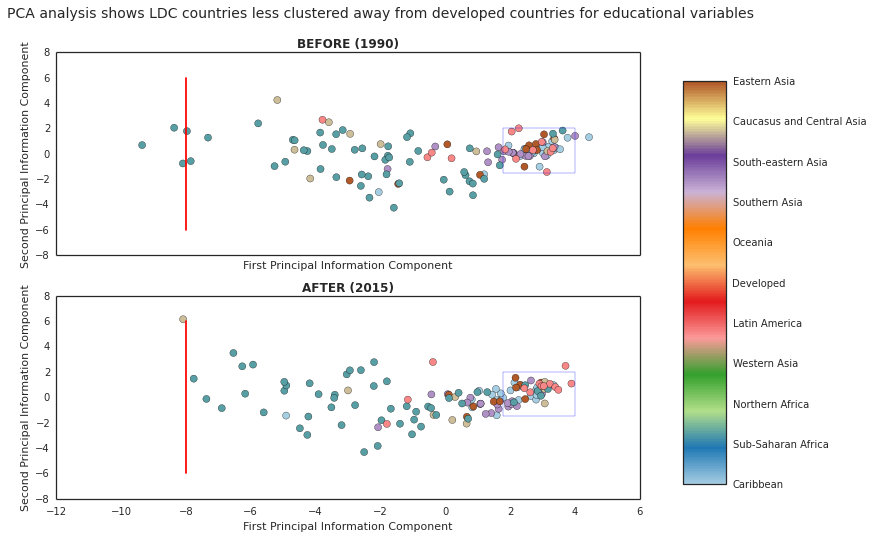

In [32]:
from matplotlib.patches import Rectangle
sns.set_style('white')
fig,axes = plt.subplots(2,sharex=True,figsize=(12,8))
fig.suptitle("PCA analysis shows LDC countries less clustered away from developed countries for educational variables", fontsize=14)
#plt.title("PCA analysis shows LDC countries less clustered away from developed countries")
for yr_ix in xrange(len(yrs)):
    x,y = 1.8,-1.5
    data = clean_ed_data.xs(yrs[yr_ix],level='Year').unstack(level='SeriesOrderClause')
    region_data = region_as_num(data.index.get_level_values('MdgRegions').values)
    norm_data = (data.values - np.mean(data.values,axis=0))/(np.std(data.values,axis=0))
    data_2d = svd.fit_transform(norm_data)
    s=axes[yr_ix].scatter(data_2d[:,0],data_2d[:,1],c=region_data,s=50,cmap=plt.cm.Paired)
    if yr_ix == 0:
        axes[yr_ix].set_title("BEFORE ("+str(yrs[yr_ix])+")", fontsize = 12, fontweight='bold')
    else:
        axes[yr_ix].set_title("AFTER ("+str(yrs[yr_ix])+")", fontsize = 12, fontweight = 'bold') 
    axes[yr_ix].set_xlabel("First Principal Information Component")
    axes[yr_ix].set_ylabel("Second Principal Information Component")
    axes[yr_ix].plot((-8, -8), (-6, 6), 'r-')
    axes[yr_ix].add_patch(Rectangle((x,y),2.2,3.5,alpha=1.0,facecolor='none',edgecolor='blue'))
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(s, cax=cbar_ax)
cbar.ax.set_yticklabels(['Caribbean', 'Sub-Saharan Africa', 'Northern Africa','Western Asia','Latin America','Developed','Oceania','Southern Asia','South-eastern Asia','Caucasus and Central Asia','Eastern Asia'])

plt.show()





As can be seen above, many Sub-Saharan African countries, who have historically underperformed on educational indicators, have cut their gap with countries in the "Developed" MDG region. ***We notice that the Sub-Saharan country which was farthest away from the developed world has moved up 2 points on the first principal information component (from -10 to -8 on the x-axis, as shown by the red line). Most Sub-Saharan African countries have also reduced their gap with the developed world on the second principal information component (moving to the middle of the y-axis). Importantly, we see that a handful of Sub-Saharan African have moved into the cluster of developed countries based on educational variables (as shown by the light blue box).***
As predicted, therefore, LDCs have made tremendous growth in advancing their gains in educational indicators compared to developed countries. Countries like Malawi that have led the way in improving maternal and child healthcare have also balanced these gains with hitting their primary education enrolment and completion rates.